#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/project1_2/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
def set_random_seed(seed=42):
    """
    모든 라이브러리의 랜덤 시드를 고정하는 함수

    Parameters:
    seed (int): 시드 값 (기본값: 42)
    """
    # 1. Python 기본 random 모듈 시드 고정
    random.seed(seed)

    # 2. NumPy 시드 고정
    np.random.seed(seed)

    # 3. 환경변수로 시드 고정 (일부 라이브러리에서 사용)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 4. PyTorch 시드 고정 (PyTorch 사용시)
    try:
        import torch
        torch.manual_seed(seed)

        # CUDA 사용시
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    except ImportError:
        pass

    # 5. TensorFlow 시드 고정 (TensorFlow 사용시)
    try:
        import tensorflow as tf
        if hasattr(tf, 'random'):
            tf.random.set_seed(seed)
        else:
            tf.set_random_seed(seed)
    except ImportError:
        pass

    print(f"모든 랜덤 시드가 {seed}로 고정되었습니다.")

# 사용법
set_random_seed(42)

모든 랜덤 시드가 42로 고정되었습니다.


In [29]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [30]:
# 주어진 데이터 셋을 불러오세요.(3개)
train = pd.read_csv(path + 'data01_train.csv')
test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [31]:
#불필요한 칼럼을 삭제하세요.
train = train.drop('subject', axis = 1)
test = test.drop('subject', axis = 1)

#### 2) 기본 정보 조회

In [32]:
#전체 데이터의 행,열 개수 확인
print(train.shape)
print(test.shape)

(5881, 562)
(1471, 562)


In [33]:
#전체 데이터의 상위 5개 행 확인
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [34]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [35]:
#전체 데이터의 수치형 변수 분포 확인
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [36]:
test.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


In [37]:
#전체 데이터의 모든 변수 확인
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [38]:
test.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [39]:
# 데이터 분할을 합니다.
x = train.drop('Activity', axis = 1)
y = train['Activity']

### (2) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [40]:
# 정수 인코딩 변환(LabelEncoder)
LE = LabelEncoder()

y_encoded = LE.fit_transform(y)
y_encoded

array([2, 0, 2, ..., 0, 5, 1])

In [41]:
# 기존 레이블 저장
LE.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [42]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
train_x, val_x, train_y, val_y = train_test_split(x, y_encoded, test_size = 0.2, stratify = y_encoded)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(4704, 561) (4704,)
(1177, 561) (1177,)


### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [43]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
MM = MinMaxScaler()
train_x_s = MM.fit_transform(train_x)
val_x_s = MM.transform(val_x)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [72]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model1 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(6, activation = 'softmax')
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# 컴파일 및 학습
model1.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')
hist1 = model1.fit(train_x_s, train_y, epochs=50, validation_split=0.2, verbose=0).history

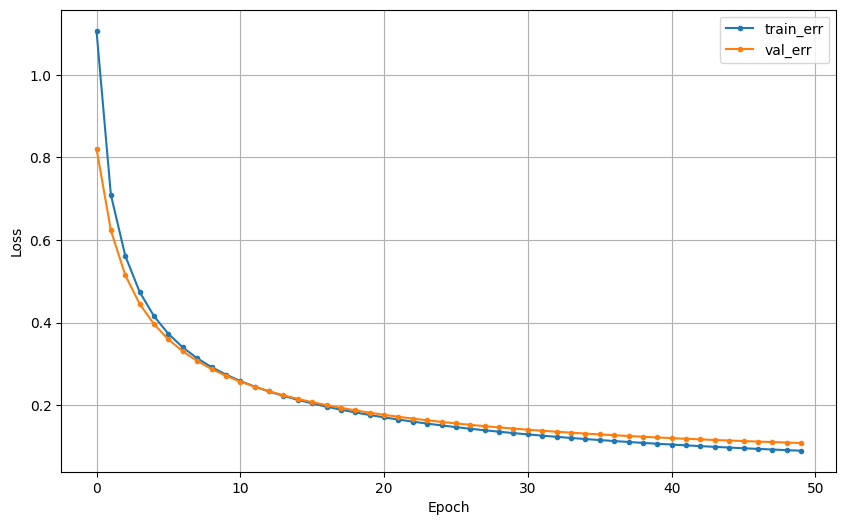

In [74]:
# 학습곡선
dl_history_plot(hist1)

In [84]:
# 예측 및 평가
y_pred = model1.predict(val_x_s)
y_pred = y_pred.argmax(axis = 1)
print(y_pred[:5])

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0 1 3 0 1]


In [85]:
print(confusion_matrix(val_y, y_pred))
print(classification_report(val_y, y_pred))
print(accuracy_score(val_y, y_pred))

[[223   0   0   0   0   0]
 [  1 186  18   0   0   1]
 [  0   9 209   0   0   0]
 [  0   0   0 196   4   0]
 [  0   0   0   0 157   1]
 [  0   0   0   1   6 165]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.95      0.90      0.93       206
           2       0.92      0.96      0.94       218
           3       0.99      0.98      0.99       200
           4       0.94      0.99      0.97       158
           5       0.99      0.96      0.97       172

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

0.9651656754460493


In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [79]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model2 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(6, activation = 'softmax')
])

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,734 (733.34 KB)

 Trainable params: 187,734 (733.34 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# 컴파일 및 학습
model2.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')
hist2 = model2.fit(train_x_s, train_y, epochs=50, validation_split=0.2, verbose=0).history

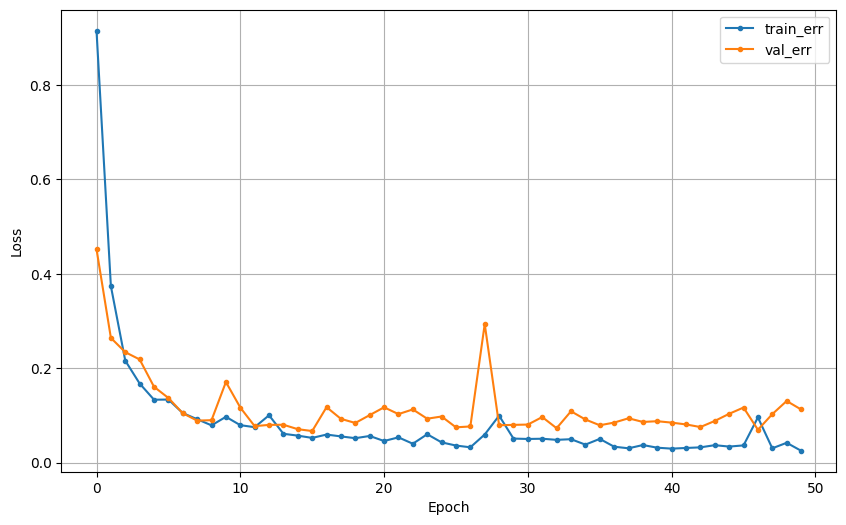

In [81]:
# 학습곡선
dl_history_plot(hist2)

In [87]:
# 예측 및 평가
y_pred = model2.predict(val_x_s)
y_pred = y_pred.argmax(axis = 1)
print(y_pred[:5])

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0 1 3 0 1]


In [88]:
print(confusion_matrix(val_y, y_pred))
print(classification_report(val_y, y_pred))
print(accuracy_score(val_y, y_pred))

[[223   0   0   0   0   0]
 [  1 186  18   0   0   1]
 [  0   4 214   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   7 149   2]
 [  0   0   0   5   0 167]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.98      0.90      0.94       206
           2       0.92      0.98      0.95       218
           3       0.94      1.00      0.97       200
           4       1.00      0.94      0.97       158
           5       0.98      0.97      0.98       172

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

0.967714528462192


### (3) 모델3 : 학습률, epoch 등 조정

In [89]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model3 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(6, activation = 'softmax')
])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,734 (733.34 KB)

 Trainable params: 187,734 (733.34 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# 컴파일 및 학습
model3.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, restore_best_weights = True)
hist3 = model3.fit(train_x_s, train_y, epochs=100, validation_split=0.2, callbacks=[es], verbose=1).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.3319 - val_loss: 0.4540
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3569 - val_loss: 0.1769
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1930 - val_loss: 0.1438
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1953 - val_loss: 0.1233
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1467 - val_loss: 0.1147
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1463 - val_loss: 0.1269
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1004 - val_loss: 0.1625
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0848 - val_loss: 0.1126
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0727 - val_loss: 0.1059
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0740 - val_loss: 0.0768
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0645 - val_loss: 0.1002
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━━

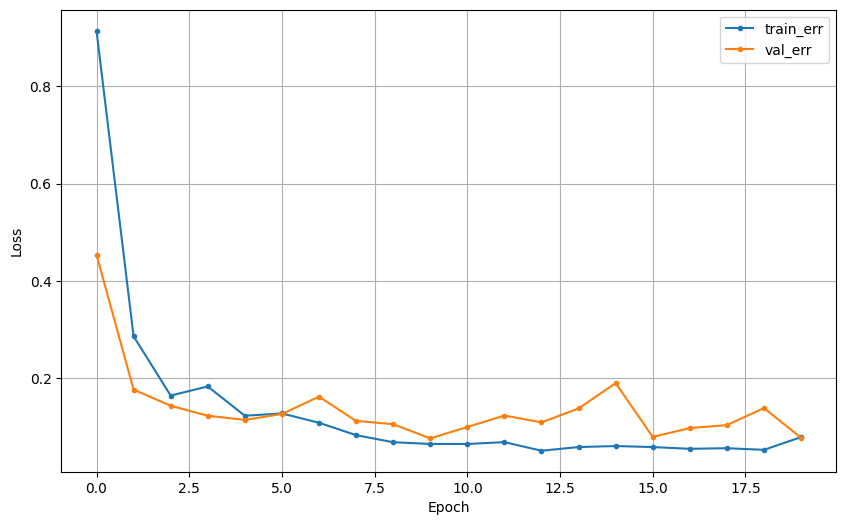

In [91]:
# 학습곡선
dl_history_plot(hist3)

In [92]:
# 예측 및 평가
y_pred = model3.predict(val_x_s)
y_pred = y_pred.argmax(axis = 1)
print(y_pred[:5])

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[0 1 3 0 1]


In [93]:
print(confusion_matrix(val_y, y_pred))
print(classification_report(val_y, y_pred))
print(accuracy_score(val_y, y_pred))

[[222   1   0   0   0   0]
 [  0 194  11   0   0   1]
 [  0  13 205   0   0   0]
 [  0   0   0 199   1   0]
 [  0   0   0   1 156   1]
 [  0   0   0   2   2 168]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.93      0.94      0.94       206
           2       0.95      0.94      0.94       218
           3       0.99      0.99      0.99       200
           4       0.98      0.99      0.98       158
           5       0.99      0.98      0.98       172

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

0.9719626168224299


### (4) 모델4 :  학습률, epoch 등 조정

In [94]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model4 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(6, activation = 'softmax')
])

model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,734 (733.34 KB)

 Trainable params: 187,734 (733.34 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# 컴파일 및 학습
model4.compile(optimizer = Adam(learning_rate = 0.01), loss = 'sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, restore_best_weights = True)
hist4 = model4.fit(train_x_s, train_y, epochs=100, validation_split=0.2, callbacks=[es], verbose=1).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.4324 - val_loss: 0.5788
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6098 - val_loss: 0.3949
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3663 - val_loss: 0.2140
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2624 - val_loss: 0.1646
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2309 - val_loss: 0.1560
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1734 - val_loss: 0.1435
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1327 - val_loss: 0.1753
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1445 - val_loss: 0.1415
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1043 - val_loss: 0.1864
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1727 - val_loss: 0.2493
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1448 - val_loss: 0.1038
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━

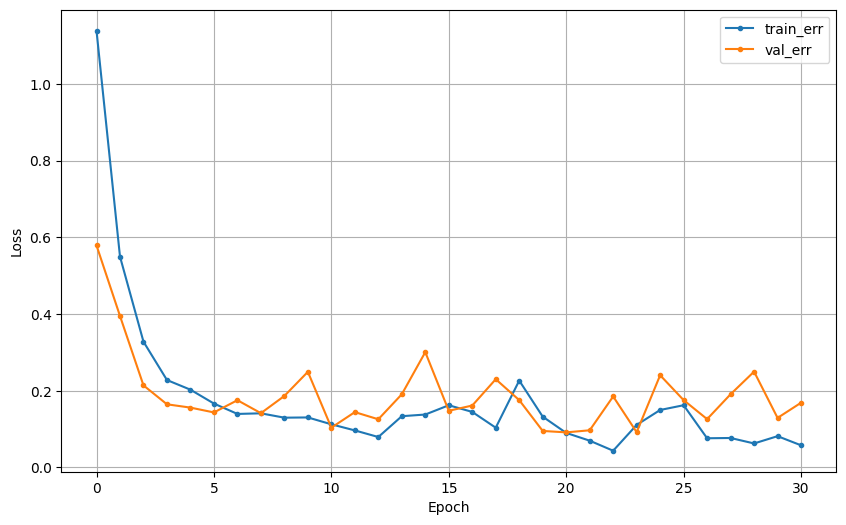

In [96]:
# 학습곡선
dl_history_plot(hist4)

In [97]:
# 예측 및 평가
y_pred = model4.predict(val_x_s)
y_pred = y_pred.argmax(axis = 1)
print(y_pred[:5])

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[0 1 3 0 1]


In [98]:
print(confusion_matrix(val_y, y_pred))
print(classification_report(val_y, y_pred))
print(accuracy_score(val_y, y_pred))

[[223   0   0   0   0   0]
 [  0 194  11   0   0   1]
 [  0   8 210   0   0   0]
 [  0   0   0 191   7   2]
 [  0   0   0   0 157   1]
 [  0   0   0   0   6 166]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.96      0.94      0.95       206
           2       0.95      0.96      0.96       218
           3       1.00      0.95      0.98       200
           4       0.92      0.99      0.96       158
           5       0.98      0.97      0.97       172

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

0.9694137638062872


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [99]:
# x, y 분할
test_x = test.drop('Activity', axis = 1)
test_y = test['Activity']

# y : 정수인코딩 적용
test_y_encoded = LE.transform(test_y)

# x : 스케일링 적용
test_x_s = MM.transform(test_x)

In [101]:
# test 데이터에 대한 성능 측정

# 모델1
y_pred1 = model1.predict(test_x_s)
y_pred1 = y_pred1.argmax(axis = 1)

acc1 = accuracy_score(test_y_encoded, y_pred1)
print(confusion_matrix(test_y_encoded, y_pred1))
print(classification_report(test_y_encoded, y_pred1))
print(acc1)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[290   0   0   0   2   0]
 [  1 218  35   0   0   0]
 [  0  16 271   0   0   0]
 [  0   0   0 223   2   3]
 [  0   0   0   0 195   0]
 [  0   0   0   1   3 211]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.93      0.86      0.89       254
           2       0.89      0.94      0.91       287
           3       1.00      0.98      0.99       228
           4       0.97      1.00      0.98       195
           5       0.99      0.98      0.98       215

    accuracy                           0.96      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471

0.9571719918422842


In [102]:
# 모델2
y_pred2 = model2.predict(test_x_s)
y_pred2 = y_pred2.argmax(axis = 1)

acc2 = accuracy_score(test_y_encoded, y_pred2)
print(confusion_matrix(test_y_encoded, y_pred2))
print(classification_report(test_y_encoded, y_pred2))
print(acc2)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[291   0   0   1   0   0]
 [  0 229  25   0   0   0]
 [  0  12 275   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   9 184   2]
 [  0   0   0  10   0 205]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.90      0.93       254
           2       0.92      0.96      0.94       287
           3       0.92      1.00      0.96       228
           4       1.00      0.94      0.97       195
           5       0.99      0.95      0.97       215

    accuracy                           0.96      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471

0.9598912304554724


In [103]:
# 모델3
y_pred3 = model3.predict(test_x_s)
y_pred3 = y_pred3.argmax(axis = 1)

acc3 = accuracy_score(test_y_encoded, y_pred3)
print(confusion_matrix(test_y_encoded, y_pred3))
print(classification_report(test_y_encoded, y_pred3))
print(acc3)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[290   1   0   1   0   0]
 [  0 235  19   0   0   0]
 [  0  21 266   0   0   0]
 [  0   0   1 226   0   1]
 [  0   0   0   0 195   0]
 [  0   0   1   5   0 209]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.91      0.93      0.92       254
           2       0.93      0.93      0.93       287
           3       0.97      0.99      0.98       228
           4       1.00      1.00      1.00       195
           5       1.00      0.97      0.98       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471

0.9660095173351462


In [104]:
# 모델4
y_pred4 = model4.predict(test_x_s)
y_pred4 = y_pred4.argmax(axis = 1)

acc4 = accuracy_score(test_y_encoded, y_pred4)
print(confusion_matrix(test_y_encoded, y_pred4))
print(classification_report(test_y_encoded, y_pred4))
print(acc4)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[290   2   0   0   0   0]
 [  0 236  18   0   0   0]
 [  0  17 270   0   0   0]
 [  0   0   0 214   9   5]
 [  0   0   0   0 195   0]
 [  0   0   0   0   7 208]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.93      0.93      0.93       254
           2       0.94      0.94      0.94       287
           3       1.00      0.94      0.97       228
           4       0.92      1.00      0.96       195
           5       0.98      0.97      0.97       215

    accuracy                           0.96      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471

0.9605710401087696


#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.